In [17]:
import copy
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from scipy.stats import ttest_ind, ranksums, mannwhitneyu
from qiime2.plugins.deicode.actions import rpca
#from qiime2.plugins.songbird.actions import multinomial
from qiime2.plugins.emperor.actions import biplot, plot
from skbio.stats.composition import alr
from skbio.stats.composition import closure

import glob

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import global feature to gene ID mapping from Prokka on bins
gff_mapping = pd.concat([pd.DataFrame([[x.split(';')[0], x.split(';')[1:]] for x in pd.read_csv(bin_gff, sep='\t', header=None)[8].values])
                         for bin_gff in glob.glob('data/metaG_functional_count_tables/*.gff')])
gff_mapping[0] = [x.split('=')[1] for x in gff_mapping[0]]
gff_mapping = gff_mapping.set_index(0)
gff_mapping.index.name = 'feature_id'
gff_mapping.columns = ['feature_information']
gff_mapping = gff_mapping.feature_information.to_dict()


In [3]:
mf = pd.read_csv('data/mapping-files/mapping-etoh-ctrl.tsv',
                     sep='\t', index_col=0)
mf.index.name = '#SampleID'
mf.index = mf.index.astype(str)
q2mf = q2.Metadata(mf)
mf.head(5)

,treatment
#SampleID,
1596,EtOH
457,EtOH
767,EtOH
300,EtOH
682,EtOH


In [4]:
# import expression tables
gene_expression_count_tables = [pd.read_csv(count_bin, sep='\t', index_col=0, skiprows=1).drop(['Chr','Start','End','Strand'], axis=1)
                                for count_bin in glob.glob('data/metaT_functional_count_tables/*.txt')]
gene_expression_count_tables = pd.concat(gene_expression_count_tables)
gene_align_length = gene_expression_count_tables['Length'].values
gene_expression_count_tables = gene_expression_count_tables.drop(['Length'], axis=1)
gene_expression_count_tables_rpk = 10**2 * (gene_expression_count_tables.T / gene_align_length).T
gene_expression_count_tables_rpk = gene_expression_count_tables_rpk.groupby(gene_expression_count_tables_rpk.index).sum()
gene_expression_count_tables_rpk.columns = [x.split('/')[-1].split('.')[1].split('_')[0] for x in gene_expression_count_tables_rpk.columns]
gene_expression_count_tables_rpk = gene_expression_count_tables_rpk[gene_expression_count_tables_rpk.sum(1) > 0]
gene_expression_count_tables_rpk.head(3)


,1596,300,457,624,626,627,668,673ctrl,673etoh,682,686,701,703,704,767,813
Geneid,,,,,,,,,,,,,,,,
ABDHCFIN_00021,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21645,0.0
ABDHCFIN_00065,0.0,0.0,0.0,0.03647,0.218818,0.109409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
ABDHCFIN_00322,0.0,0.0,0.0,0.00000,0.000000,0.406504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0


In [5]:
# subset EC numbers
gff_mapping_ec = {k:v[0].replace('eC_number=', '') for k, v in gff_mapping.items()
                  if any('eC_number' in v_i for v_i in v)}
all_ec = set(gene_expression_count_tables_rpk.index) & set(gff_mapping_ec.keys())
gene_expression_count_tables_rpk_ec = gene_expression_count_tables_rpk.reindex(all_ec)
gene_expression_count_tables_rpk_ec.index = [gff_mapping_ec[x] for x in gene_expression_count_tables_rpk_ec.index]
gene_expression_count_tables_rpk_ec = gene_expression_count_tables_rpk_ec.groupby(gene_expression_count_tables_rpk_ec.index).sum()
gene_expression_count_tables_rpk_ec.head(5)


,1596,300,457,624,626,627,668,673ctrl,673etoh,682,686,701,703,704,767,813
1.-.-.-,0.306164,2.302647,6.635273,47.967920,176.112791,25.056512,0.361366,5.943539,81.327391,5.015448,6.747092,46.947713,0.267033,1.675482,0.054735,56.317409
1.1.-.-,0.000000,0.000000,0.000000,0.000000,0.097466,0.194932,0.000000,0.097466,0.000000,0.000000,0.000000,0.083963,0.000000,0.000000,0.000000,0.000000
1.1.1.-,0.088889,1.866887,8.402162,8.718599,31.230419,11.761358,1.031944,3.115454,45.514967,4.118187,6.403518,28.420318,0.462038,0.862514,0.087489,28.409425
1.1.1.1,0.000000,0.000000,0.385356,1.252969,0.781350,2.684644,0.096339,0.000000,6.298800,0.222222,0.915106,3.345523,0.000000,0.000000,0.000000,4.269875
1.1.1.100,0.126263,1.625796,3.592568,3.287732,12.883877,9.399746,0.133869,1.605716,32.394936,0.950303,1.157978,16.868819,0.133333,0.673729,0.000000,20.372972


In [6]:
# apply ALR transformation in RPK data with rpoB as the normalization feature
gene_expression_count_tables_rpk_ec_alr = gene_expression_count_tables_rpk_ec.copy().T + 0.5
gene_ids = list(gene_expression_count_tables_rpk_ec_alr.columns)
rpo_idx = gene_ids.index('2.7.7.6')
gene_ids.remove('2.7.7.6')
alr_vals = alr(gene_expression_count_tables_rpk_ec_alr.values, denominator_idx=rpo_idx)
alr_vals[~np.isfinite(alr_vals)] = np.nan
gene_expression_count_tables_rpk_ec_alr = pd.DataFrame(alr_vals,
                                                      gene_expression_count_tables_rpk_ec_alr.index,
                                                      gene_ids)
gene_expression_count_tables_rpk_ec_alr.head(5)


,1.-.-.-,1.1.-.-,1.1.1.-,1.1.1.1,1.1.1.100,1.1.1.103,1.1.1.108,1.1.1.119,1.1.1.122,1.1.1.127,...,6.4.-.-,6.4.1.2,6.4.1.3,6.4.1.7,6.4.1.8,6.5.1.-,6.5.1.2,6.5.1.4,6.6.1.1,6.6.1.2
1596,-1.100435,-1.578115,-1.414486,-1.578115,-1.352953,-1.578115,-1.578115,-1.578115,-1.578115,-1.578115,...,-1.578115,-1.356708,-1.074931,-1.468053,-1.578115,-1.578115,-1.108744,-1.578115,-1.578115,-1.578115
300,-0.794025,-2.517736,-0.963014,-2.517736,-1.070443,-2.517736,-2.168508,-2.517736,-2.517736,-2.517736,...,-2.517736,-2.405448,-1.746236,-2.064779,-2.517736,-2.367416,-2.256289,-2.517736,-2.517736,-2.517736
457,-0.874708,-3.532906,-0.653464,-2.961523,-1.430586,-3.532906,-3.532906,-3.283169,-3.532906,-2.956694,...,-3.532906,-3.532906,-2.676699,-3.190504,-3.532906,-3.382586,-2.688562,-3.532906,-3.532906,-3.532906
624,-0.580200,-5.154249,-2.239879,-3.899791,-3.129334,-4.403951,-4.964467,-5.154249,-5.154249,-4.921997,...,-4.971258,-3.385398,-2.295530,-4.068820,-4.982596,-4.089902,-3.355166,-5.154249,-5.154249,-4.885441
626,-0.332022,-6.021040,-2.048706,-5.258068,-2.911931,-4.282581,-4.554377,-6.199129,-6.199129,-4.510126,...,-6.073494,-3.349591,-2.487376,-4.139282,-5.561114,-3.999911,-3.450036,-6.199129,-6.199129,-5.855020


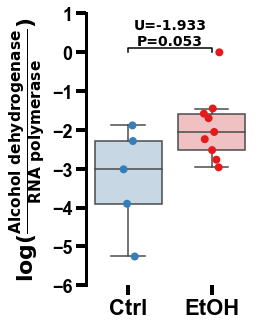

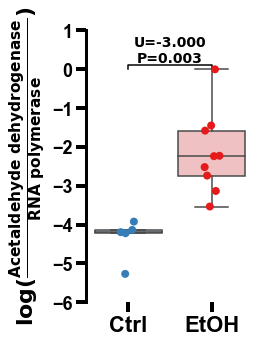

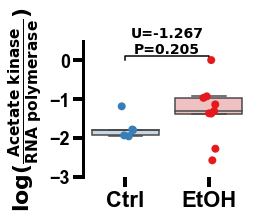

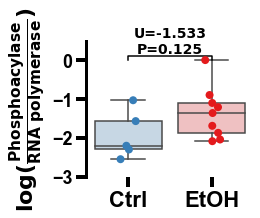

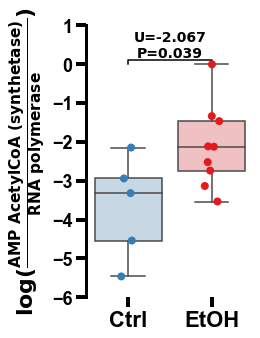

In [31]:
labels_ac = {'1.1.1.1':'Alcohol dehydrogenase' ,
             '1.2.1.10':'Acetaldehyde dehydrogenase',
             '2.7.2.1':'Acetate kinase',
             '2.3.1.8':'Phosphoacylase',
             '6.2.1.1':'AMP AcetylCoA (synthetase)'}

order_ = ['Ctrl', 'EtOH']
pallet_ = {'Ctrl':'#377eb8',
           'EtOH':'#e41a1c'}
pavals = []

for ec_id, id_name in labels_ac.items():

    # make copy of metadata and add LR
    mf_lr = mf.copy()
    mf_lr[id_name] = gene_expression_count_tables_rpk_ec_alr.loc[mf_lr.index, ec_id]
    mf_lr = mf_lr.dropna(subset=[id_name])
    
    if ec_id in ['2.3.1.8','2.7.2.1']:
        fig, ax = plt.subplots(1,1, figsize=(3, 2.5))
    else:
        fig, ax = plt.subplots(1,1, figsize=(3, 5))

    sns.boxplot(y=id_name, x='treatment', data=mf_lr, ax=ax,
                order=order_, palette=pallet_, showfliers=False)
    sns.stripplot(y=id_name, x='treatment', data=mf_lr, ax=ax,
                  s=8, order=order_, palette=pallet_)
    
    ax.set_ylabel('log($\\frac{\\mathbf{%s}}{\\mathbf{%s}}$)' 
                  % (id_name.replace(' ','\,\,'), 'RNA\,\,polymerase'),
                  fontsize=22, weight='bold', color='black')
    ax.set_xlabel('')
    
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    """ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")"""
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        #tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(18)
        
    # statistical annotation
    x1, x2 = 0, 1  
    #t_, p_ = ttest_ind(mf_lr.loc[mf_lr.treatment == 'Ctrl', id_name].values,
    #                   mf_lr.loc[mf_lr.treatment == 'EtOH', id_name].values,
    #                   equal_var=False)
    t_, p_ = ranksums(mf_lr.loc[mf_lr.treatment == 'Ctrl', id_name].values,
                       mf_lr.loc[mf_lr.treatment == 'EtOH', id_name].values)
    pavals.append(p_)
    stat_annot = "U=%.3f\nP=%.3f" % (t_, p_)
    y, h, col = mf_lr[id_name].max() + 0, .1, 'black'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, stat_annot, ha='center',va='bottom',
             color=col, weight='bold', fontsize=14)

    ax.spines['left'].set_bounds(ax.get_yticks().min(), ax.get_yticks().max())
    ax.set_ylim(ax.get_yticks().min(), ax.get_yticks().max())
    
    plt.savefig('results/figures/lr-expression-%s.pdf' % (ec_id),
                dpi=600, 
                bbox_inches='tight',
                edgecolor='none')

    plt.show()
